<a href="https://colab.research.google.com/github/Mattemathics/Machine-Learning-Python/blob/BR-01/CbC_reject_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##CbC with reject option applied to mnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
################parameters defined
k = 9
c = 10
eps = 0.01
train_iter = 500
test_iter = 100
data_dim = 28*28
lambVal = 0.01
ts =0.88

In [ ]:
#define the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train,(60000,data_dim))
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = np.reshape(x_test,(10000,data_dim))
x_test = tf.keras.utils.normalize(x_test, axis=1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
###define adaptable parameters
prototypes = np.zeros((k,data_dim))

for i in range(1000):
    if y_train[i] <k:
        prototypes[y_train[i]] = prototypes[y_train[i]] + x_train[i]

for i in range(k):
    prototypes[i] = prototypes[i]/np.linalg.norm(prototypes[i])


pos_reasoning = 0.7* np.eye(c,k)
neg_reasoning = 0.2* (np.ones((c,k)) - np.eye(c,k))
neu_reasoning = np.ones((c,k)) - pos_reasoning - neg_reasoning

In [ ]:
####define functions
def N(x):
    vec = predictor(x)
    return np.sum(vec)

def theta(j):
    cird = 0
    for z in range(k):
        cird = cird + (1 - neu_reasoning[j, z])
    bilds = np.maximum(pos_reasoning[j],neg_reasoning[j])
    return (1/(1-ts)) * (1/cird) * np.sum(bilds)

def H(x,gamma):
    inp = maxp(x)+ts-1
    return sig(inp,gamma)

def maxp(x):
    y_pred = predictorp(x)
    s = np.argmax(y_pred)
    return y_pred[s]

def maxl(x):
    y_pred = predictorp(x)
    s = np.argmax(y_pred)
    return s

def sig(x,lam):
    return 1/(1+np.exp(-(x/lam)))

def phi(x,y,lam):
    return (1/lam) * sig(deltaP(x,y),lam) * (1-sig(deltaP(x,y),lam))

def deltaP(x, y_true):
        y_pred = predictorp(x)
        tem = y_pred
        s = np.argmax(y_pred)
        if s == y_true:
            tem[s] = 0
            s = np.argmax(tem)
        return y_pred[s] - y_pred[y_true]


def FirstAndSecond(x, y_true):
        y_pred = predictorp(x)
        tem = y_pred
        s = np.argmax(y_pred)
        if s == y_true:
            tem[s] = 0
            s = np.argmax(tem)
        return s


def d(x,w):
    out = np.maximum(np.dot(x,w)+0.3, 0)
    return out


def Dd(x,w):
    de = d(x,w)
    if de <= 0:
        out = 0
    if de > 0:
        out = x
    return out

def dv(x):
    out = np.zeros(k)
    for i in range(k):
        out[i] = d(x,prototypes[i])
    return out

def predictor(x):
    prob = np.zeros(c)
    for j in range(c):
        ard = 0
        bird = 0
        cird = 0
        for t in range(k):
            ard = ard + d(x, prototypes[t]) * pos_reasoning[j,t]
            bird = bird + (1- d(x, prototypes[t])) * neg_reasoning[j,t]
            cird = cird + (1 - neu_reasoning[j,t])
        prob[j] = (ard + bird)/cird
    return prob

def predictorp(x):
    vec = predictor(x)
    return vec/np.sum(vec)

def derivativePW(x,t,j):
    pr = predictor(x)
    Nn = np.sum(pr)
    return (1/Nn)**2 * derivativePhW(x,t,j) * Nn - derivaitveNW(x,t) * pr[j]

def derivaitveNW(x,t):
    temp = 0
    for j in range(c):
        temp = derivativePhW(x, t, j) + temp
    return temp

def derivativePhW(x,t,j):
    cird = 0
    for z in range(k):
        cird = cird + (1 - neu_reasoning[j,z])
    return (1/cird)*((pos_reasoning[j,t] - neg_reasoning[j,t])* Dd(x,prototypes[t]))

def derivativerp(x,j,t):
    cird = 0
    pr = predictor(x)
    Nn = np.sum(pr)
    for z in range(k):
        cird = cird + (1 - neu_reasoning[j, z])
    return (Nn-pr[j])*d(x,prototypes[t])/(cird * Nn**2)

def derivativern(x,j,t):
    cird = 0
    pr = predictor(x)
    Nn = np.sum(pr)
    for z in range(k):
        cird = cird + (1 - neu_reasoning[j, z])
    return (Nn - pr[j]) * (1-d(x, prototypes[t])) / (cird * Nn ** 2)


In [ ]:
##training phase
for ii in range(train_iter):
    i= ii % 200
    gammaVal = 1/(ii+1)
    arda = phi(x_train[i], y_train[i], lambVal)
    S = FirstAndSecond(x_train[i], y_train[i])
    Hi = H(x_train[i],gammaVal)
    aterm = (1/gammaVal) * (1-Hi) * (sig(deltaP(x_train[i],y_train[i]),lambVal)-ts)
    for t in range(k):
        W_grad = Hi*(aterm * derivativePW(x_train[i],t,maxl(x_train[i]))+ arda * (derivativePW(x_train[i],t,S) - derivativePW(x_train[i],t,y_train[i])))
        prototypes[t] = prototypes[t] - eps * W_grad
        prototypes[t] = prototypes[t] / np.linalg.norm(prototypes[t])


    for t in range(k):
        if maxl(x_train[i]) == S:
            tem = pos_reasoning[S,t] - eps * Hi*((aterm+arda) * derivativerp(x_train[i],S,t))
        if maxl(x_train[i]) != S:
            tem = pos_reasoning[S, t] - eps * Hi * arda * derivativerp(x_train[i], S, t)
        if tem<1 and tem>0:
            pos_reasoning[S, t] = tem

        if maxl(x_train[i]) != y_train[i]:
            tem = pos_reasoning[y_train[i],t] + eps * Hi * arda * derivativerp(x_train[i], y_train[i],t)
        if maxl(x_train[i]) == y_train[i]:
            tem = pos_reasoning[y_train[i],t] + eps * Hi * ((aterm+arda) * derivativerp(x_train[i], y_train[i],t))
        if tem<1 and tem>0:
            pos_reasoning[y_train[i], t] =tem

        if maxl(x_train[i]) != S:
            tem = neg_reasoning[S,t] - eps * Hi * arda * derivativern(x_train[i],S,t)
        if maxl(x_train[i]) == S:
            tem = neg_reasoning[S,t] - eps * Hi * ((aterm+arda) * derivativern(x_train[i],S,t))
        if tem<1 and tem>0:
            neg_reasoning[S, t] = tem
        if maxl(x_train[i]) != y_train[i]:
            tem =  neg_reasoning[y_train[i], t] + eps * Hi * arda * derivativern(x_train[i], y_train[i],t)
        if maxl(x_train[i]) == y_train[i]:
            tem =  neg_reasoning[y_train[i], t] + eps * Hi * ((aterm+arda) * derivativern(x_train[i], y_train[i],t))
        if tem<1 and tem>0:
            neg_reasoning[y_train[i], t] =tem

    neu_reasoning = np.ones((c, k)) - pos_reasoning - neg_reasoning

In [ ]:
##evaluation phase
count = 0
accepted = 0
rejectedSamples = np.zeros((1,2))

for i in range(test_iter):
    ay = np.argmax(predictorp(x_test[i]))
    may = y_test[i]
    if maxp(x_test[i]) > (1 - ts):
        accepted = accepted +1
        if ay == may:
            count = count +1
    #if maxp(x_test[i]) < (1 - ts):
     #   print(dv(x_test[i]))
      #  print(y_test[i])

print("accuarcy is ", count/accepted)
print(accepted)

accuarcy is  1.0
31


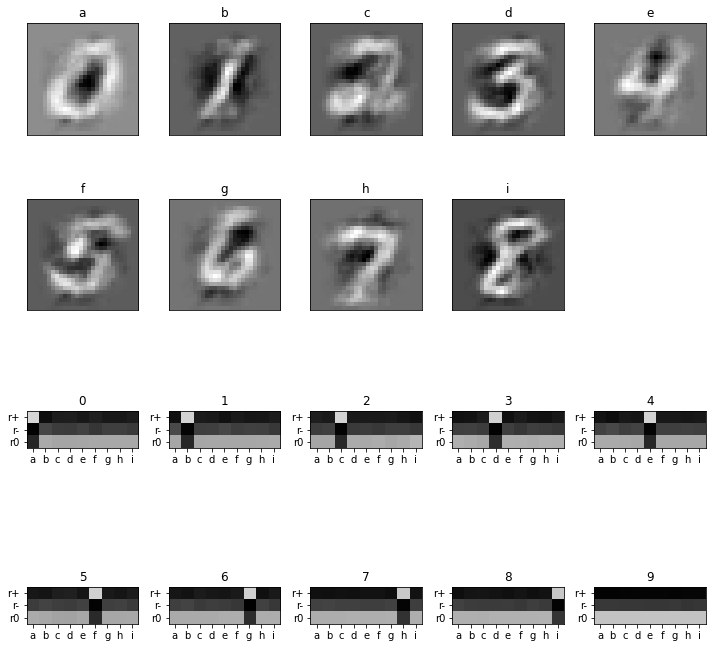

[[0.84289326 0.05807844 0.11656816 0.12056291 0.09519779 0.12933203
  0.09650349 0.09405316 0.1153986 ]
 [0.06365955 0.8316876  0.10590797 0.09945962 0.06744242 0.10286797
  0.08600614 0.09066575 0.1110291 ]
 [0.11777505 0.10300771 0.82636334 0.10166912 0.10273796 0.10350115
  0.10651669 0.08918625 0.07006068]
 [0.06866443 0.07764086 0.11070125 0.81413194 0.06632128 0.10568973
  0.07754336 0.06993924 0.09412132]
 [0.07439075 0.05242667 0.09407253 0.08258959 0.82823764 0.0967103
  0.09645141 0.08741039 0.09591398]
 [0.09337114 0.07982942 0.11886883 0.12587025 0.08564726 0.81848784
  0.09904115 0.08433626 0.11280569]
 [0.0889588  0.07051171 0.1067539  0.09195955 0.08554509 0.10444065
  0.8192625  0.06442388 0.09895612]
 [0.06497296 0.06156841 0.06924941 0.06372071 0.07225243 0.07177517
  0.05675437 0.78623851 0.07362139]
 [0.05833978 0.07834279 0.08529961 0.07561002 0.06603476 0.08065481
  0.06162109 0.07380822 0.78058464]
 [0.01342388 0.01181039 0.01691333 0.01998444 0.02288739 0.022867

In [ ]:
#######Visualization part

tex = ['a','b','c','d','e','f','g','h','i']
numer = np.array(range(9))
numer2 = np.array(range(3))
tex2 = ['r+','r-','r0']


fig = plt.figure(figsize=(10,10))

for i in range(k):
    fig.add_subplot(4, 5, i+1)
    img = np.reshape(prototypes[i],(28,28))
    plt.imshow(img, cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.title(tex[i])

for i in range(c):
    fig.add_subplot(4, 5, i+11)
    img = np.stack((pos_reasoning[i], neg_reasoning[i], neu_reasoning[i]))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.yticks(numer2, tex2)
    plt.xticks(numer, tex)
    plt.title(i)
    #ax0.title.set_text('zero')


#shades = np.linspace(0,1,11)
#im = np.reshape(shades, (1, 11))
#fig.add_subplot(4, 1, 4)
#plt.imshow(im, cmap='gray', vmin=0, vmax=1)
#y = np.array(range(11))
#shades = np.around(shades, 2)
#plt.xticks(y, shades)
#plt.yticks([])

plt.tight_layout()
plt.show()

print(pos_reasoning)
print(neg_reasoning)
print(neu_reasoning)